# Code explanation
## metrics design
For emdat dataset,first select the needed columns and observe the number of missing values in each column, I did not fill the numerical columns, such as "total damage", "death people number" with 0, because this might affect the accuracy of the analysis. Instead, I kept only the rows with values in the columns "Total Deaths", "Total Affected" and "Total Damages ('000 US$)" for the analysis.Then do pre-processing operations such as deleting rows without time and merging date data into one single column. 

We give the emdat dataset four new metrics, "death score","affected score","damage score" and " severity score", the first three metrics represent ranking of this natural disaster among all remaining emdat dataset based on number of people killed, number of people affected and total economic losses respectively. For example, if a natural disaster has thess three score 0.3,0.5 and 0.8, that means it kills more people than 30% of other natural disasters, affects more people than 50% of other natural disasters, and causes more economic damage than 80% of other natural disasters. Severity score is a combination of the above three metrics that assesses the overall bad impact caused by a natural disaster.

For the quotation dataset, we intercepted the data from 2019-01-01 to 2020-04-16 containing keyword “climate change”，This is because for the 2020's data, data are missing after April 16. For each day from 2019-01-01 to 2020-04-09, we give this date two metrics that represents the reporting intensity of climate change for the week after this date, "num_quota" represents how many different quotes about climate change were generated during the week, and "total_occur" represents the total number of these quotes pulished, respectively.

## Analysis
The analysis is based on three main aspects.

1. Will the occurrence of natural disasters spark more reports and discussions about climate change in the coming week？

First we calculate the several statistical metricsrs  of "num_quota" and "total_occur" for all date from 2019-01-01 to 2020-04-16 as baseline. This represents the intensity of media reporting and discussion of climate change in general. Then calculate the several statistical metricsrs  of "num_quota" and "total_occur for all date of the natural disaster happening. We can learn from the results that the occurrence of natural disasters does trigger more media coverage and discussion about climate change, but this effect is very small.

2. Is there a correlation between the intensity of media reporting and discussion generated by natural disasters of different severity?

We plotted scatter plots for each of the four natural disaster assessment metrics and the total number of citations and occurrences in the coming week, and calculated their correlation coefficients and p-values. It is concluded that there is no correlation between the severity of natural disasters and the intensity of media reporting and discussion they generate.

3. Does the occurrence of natural disasters in different regions have an different impact on the intensity of media discussion and reporting of climate change?

First we find an extreme value of the quoted data, by querying the emdat dataset, it was found that this reported and discussed spike corresponds to Tropical Storm Imelda happened in U.S., which generated the most discussion even though the damage caused by this natural disaster was not particularly severe. We then analyzed the other natural disasters that generated great media coverage and discussion and found that most of them occurred in countries where English is the primary language. Because the Quotation Dataset is based on English，So the region of the disaster occurrence have an impact on the intensity of media reporting and discussion, only when a natural disaster occurs in a certain country, that country's concern about climate change causing more severe natural disasters rise significantly.

## Overall Conclusion

Based on the analysis of the above three issues，we can summarize that the occurrence of natural disasters does lead to more media reports and discussions about climate change, but the severity of the natural disaster is not the main factor that leads to discussions about climate change, the area where the disaster occurs is the main factor. When a natural disaster occurs in a country, even if it is severe, other countries show less worry and concern about the natural disaster itself and the climate change that triggered them, but there is a lot of discussion about climate change within that country. In other words, people always tend to focus on what they can perceive in front of them.

In [161]:
import pandas as pd
import numpy as np
import bz2
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec
import pickle
import os
from extraction_helpers import *

In [162]:
data = 'data/emdat.csv'

#select useful columns
col_list = \
["Dis No","Year", "Disaster Group", "Disaster Subgroup", "Dis Mag Value", "Dis Mag Scale",
 "Disaster Type", "Disaster Subtype", "Disaster Subsubtype",
 "Event Name", "Country", "ISO", "Region", "Continent", "Origin","OFDA Response","Appeal","Declaration","Aid Contribution",
 "Start Year", "Start Month", "Start Day", "End Year", "End Month", "Latitude","Longitude",
 "End Day", "Total Deaths", "No Injured", "No Affected", "No Homeless", 
 "Total Affected", "Reconstruction Costs ('000 US$)", 
 "Insured Damages ('000 US$)","Total Damages ('000 US$)"]

df_emdat = pd.read_csv(data, usecols=col_list, index_col="Dis No")

print(df_emdat.shape)

(2164, 34)


In [163]:
#Checking for data vacancies and romove some vacancy rows
num = df_emdat.isna().sum()
print(num)
num_list = \
["Total Deaths", "Total Affected","Start Month","Start Day","End Month","End Day",
 "Total Damages ('000 US$)"]
df_emdat = df_emdat.dropna(axis=0, how='any',subset=num_list)
print(df_emdat.shape)

Year                                  0
Disaster Group                        0
Disaster Subgroup                     0
Disaster Type                         0
Disaster Subtype                    645
Disaster Subsubtype                1930
Event Name                         1713
Country                               0
ISO                                   0
Region                                0
Continent                             0
Origin                             1279
OFDA Response                      2066
Appeal                             2144
Declaration                        1948
Aid Contribution                   2162
Dis Mag Value                      1533
Dis Mag Scale                       143
Latitude                           1769
Longitude                          1771
Start Year                            0
Start Month                          10
Start Day                           165
End Year                              0
End Month                             0


In [164]:
#use data befor 2020
df_emdat = df_emdat[df_emdat['Start Year'] <= 2020]
print(df_emdat.shape)

(521, 34)


In [165]:
#sort data
date_cols = ["Start Year", "Start Month", "Start Day",
             "End Year", "End Month", "End Day"]
df_emdat = df_emdat.sort_values(by=date_cols)

In [166]:
# Combine start date into single olumn 
df_emdat_start = df_emdat[["Start Year", "Start Month", "Start Day"]].copy()
df_emdat_start.columns = ["year", "month", "day"]
df_emdat["StartDate"] = pd.to_datetime(df_emdat_start)

# Combine end date into single column 
df_emdat_end = df_emdat[["End Year", "End Month", "End Day"]].copy()
df_emdat_end.columns = ["year", "month", "day"]
df_emdat["EndDate"] = pd.to_datetime(df_emdat_end)

print(df_emdat.shape)
#print(df_emdat["StartDate"])

(521, 36)


In [167]:
df_emdat.drop(date_cols, axis=1, inplace=True)
print(df_emdat.shape)
df_emdat.head(5)

(521, 30)


,Year,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,ISO,Region,...,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),StartDate,EndDate
Dis No,,,,,,,,,,,,,,,,,,,,,
2015-0011-MWI,2015,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,Malawi,MWI,Eastern Africa,...,278.0,645.0,638000.0,NaN,638645.0,NaN,NaN,390000.0,2015-01-01,2015-01-21
2015-0016-MDG,2015,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Chedza',Madagascar,MDG,Eastern Africa,...,89.0,37.0,NaN,173970.0,174007.0,NaN,NaN,36000.0,2015-01-16,2015-01-17
2015-0017-PHL,2015,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Amang' (Mekkhala),Philippines (the),PHL,South-Eastern Asia,...,2.0,NaN,21687.0,NaN,21687.0,NaN,NaN,1000.0,2015-01-19,2015-01-19
2015-0074-MDG,2015,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Fundi',Madagascar,MDG,Eastern Africa,...,6.0,NaN,NaN,8430.0,8430.0,NaN,NaN,10000.0,2015-02-07,2015-02-08
2015-0044-ARG,2015,Natural,Meteorological,Storm,Convective storm,Rain,NaN,Argentina,ARG,South America,...,8.0,NaN,4500.0,NaN,4500.0,NaN,NaN,17200.0,2015-02-15,2015-02-24


In [168]:
#set death score
list_death = []

for index, value in df_emdat["Total Deaths"].iteritems():
    current = value
    k = 0
    for index_, value_ in df_emdat["Total Deaths"].iteritems():
        if current > value_:
            k = k+1
    per = k/521
    list_death.append(per)
    
print(len(list_death))
df_emdat['death score'] = list_death
print(df_emdat['death score'].describe())
df_emdat['death score'].head()

521
count    521.000000
mean       0.485958
std        0.299924
min        0.000000
25%        0.238004
50%        0.497121
75%        0.744722
max        0.998081
Name: death score, dtype: float64


Dis No
2015-0011-MWI    0.950096
2015-0016-MDG    0.865643
2015-0017-PHL    0.055662
2015-0074-MDG    0.291747
2015-0044-ARG    0.349328
Name: death score, dtype: float64

In [169]:
#affected score
list_affected = []
for index, value in df_emdat["Total Affected"].iteritems():
    current = value
    k = 0
    for index_, value_ in df_emdat["Total Affected"].iteritems():
        if current > value_:
            k = k+1
    per = k/521
    list_affected.append(per)
    
print(len(list_affected))
df_emdat['affected score'] = list_affected
print(df_emdat['affected score'].describe())
df_emdat['affected score'].head()

521
count    521.000000
mean       0.498226
std        0.289564
min        0.000000
25%        0.247601
50%        0.499040
75%        0.748560
max        0.998081
Name: affected score, dtype: float64


Dis No
2015-0011-MWI    0.857965
2015-0016-MDG    0.748560
2015-0017-PHL    0.541267
2015-0074-MDG    0.389635
2015-0044-ARG    0.307102
Name: affected score, dtype: float64

In [170]:
#damage score
list_damage = []
for index, value in df_emdat["Total Damages ('000 US$)"].iteritems():
    current = value
    k = 0
    for index_, value_ in df_emdat["Total Damages ('000 US$)"].iteritems():
        if current > value_:
            k = k+1
    per = k/521
    list_damage.append(per)
    
print(len(list_damage))
df_emdat['damage score'] = list_damage
print(df_emdat['damage score'].describe())
df_emdat['damage score'].head()

521
count    521.000000
mean       0.494848
std        0.291363
min        0.000000
25%        0.247601
50%        0.499040
75%        0.748560
max        0.998081
Name: damage score, dtype: float64


Dis No
2015-0011-MWI    0.644914
2015-0016-MDG    0.295585
2015-0017-PHL    0.019194
2015-0074-MDG    0.142035
2015-0044-ARG    0.207294
Name: damage score, dtype: float64

In [171]:
#generate whole severity score
df_emdat_processed = df_emdat.copy()
list_severe=np.sum([list_death,list_affected,list_damage],axis=0).tolist()
print(len(list_severe))
df_emdat_processed['severe score'] = list_severe
print(df_emdat_processed['severe score'].describe())
df_emdat_processed.head()

521
count    521.000000
mean       1.479032
std        0.648609
min        0.109405
25%        0.978887
50%        1.408829
75%        1.976967
max        2.944338
Name: severe score, dtype: float64


,Year,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,ISO,Region,...,Total Affected,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),StartDate,EndDate,death score,affected score,damage score,severe score
Dis No,,,,,,,,,,,,,,,,,,,,,
2015-0011-MWI,2015,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,Malawi,MWI,Eastern Africa,...,638645.0,NaN,NaN,390000.0,2015-01-01,2015-01-21,0.950096,0.857965,0.644914,2.452975
2015-0016-MDG,2015,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Chedza',Madagascar,MDG,Eastern Africa,...,174007.0,NaN,NaN,36000.0,2015-01-16,2015-01-17,0.865643,0.748560,0.295585,1.909789
2015-0017-PHL,2015,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Amang' (Mekkhala),Philippines (the),PHL,South-Eastern Asia,...,21687.0,NaN,NaN,1000.0,2015-01-19,2015-01-19,0.055662,0.541267,0.019194,0.616123
2015-0074-MDG,2015,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Fundi',Madagascar,MDG,Eastern Africa,...,8430.0,NaN,NaN,10000.0,2015-02-07,2015-02-08,0.291747,0.389635,0.142035,0.823417
2015-0044-ARG,2015,Natural,Meteorological,Storm,Convective storm,Rain,NaN,Argentina,ARG,South America,...,4500.0,NaN,NaN,17200.0,2015-02-15,2015-02-24,0.349328,0.307102,0.207294,0.863724


In [172]:
print(df_emdat_processed.shape)

(521, 34)


In [173]:
#load quota dataset

filename_1 = open("extracted_data/output_2019 speakers_False keywords_['hurricane', 'climate change'].pickle", "rb")
dict_df_1 = pickle.load(filename_1)

filename_2 = open("extracted_data_other/output_2020 speakers_False keywords_['hurricane', 'climate change'].pickle", "rb")
dict_df_2 = pickle.load(filename_2)

In [174]:
for keyword in dict_df_1:
    for index, row in dict_df_1[keyword].iterrows():
        dict_df_1[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])
print(type(dict_df_1))

for keyword in dict_df_2:
    for index, row in dict_df_2[keyword].iterrows():
        dict_df_2[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])
print(type(dict_df_1))



C:\Users\renpe\AppData\Local\Temp/ipykernel_25884/3690838737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df_1[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])


<class 'dict'>


C:\Users\renpe\AppData\Local\Temp/ipykernel_25884/3690838737.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df_2[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])


<class 'dict'>


In [175]:
for keyword in dict_df_1:
    dict_df_1[keyword] = dict_df_1[keyword].sort_values('date', ascending=True)
    
for keyword in dict_df_2:
    dict_df_2[keyword] = dict_df_2[keyword].sort_values('date', ascending=True)

In [176]:
quota_df_2019=dict_df_1[ 'climate change']
quota_df_2020=dict_df_2[ 'climate change']
#merge quota data in 2019 and 2020
quota_df = pd.concat([quota_df_2019,quota_df_2020])
quota_df.shape

(44935, 10)

In [177]:
quota_df['date']=pd.to_datetime(quota_df['date'])
quota_df.head(5)

,quoteID,quotation,speaker,qids,date,probas,numOccurences,phase,numOccurrences,urls
34659,2019-01-01-043321,to stop climate change and create millions of ...,None,[],2019-01-01,"[[None, 0.7532], [Alexandria Ocasio-Cortez, 0....",NaN,E,3.0,[http://www.startribune.com/numbing-new-year-5...
34696,2019-01-01-028877,"Oh, my gosh. I wish I knew. I wish a had a goo...",Kate Marvel,[Q55640226],2019-01-01,"[[Kate Marvel, 0.7528], [None, 0.1391], [Chuck...",NaN,E,1.0,[https://blogs.timesofisrael.com/we-have-30-mo...
34555,2019-01-01-034655,that the Mills administration is serious about...,None,[],2019-01-01,"[[None, 0.9516], [Gov. Paul LePage, 0.0484]]",NaN,E,2.0,[https://www.centralmaine.com/2019/01/01/mills...
30203,2019-01-01-023973,It's obviously extraordinarily difficult to do...,Chuck Todd,[Q1089199],2019-01-01,"[[Chuck Todd, 0.8128], [None, 0.1872]]",NaN,E,1.0,[https://www.westernjournal.com/ct/nbc-censors...
27510,2019-01-01-018703,"I'll fight to address climate change, immigrat...",Angie Craig,[Q58324174],2019-01-01,"[[Angie Craig, 0.8459], [None, 0.1298], [Donna...",NaN,E,1.0,[https://www.breitbart.com/politics/2019/01/01...


In [179]:
#Intensity of reports on climate change in the next 7 days, quota after 2020-4-16 is vacant

day_array=np.arange('2019-01-01', '2020-04-09', dtype='datetime64[D]')

num_quota_list = []
total_occur_list = []
for day in day_array:
    next_day = day + np.timedelta64(7, 'D')
    mask = ((quota_df['date'] >= day ) & (quota_df['date'] < next_day))
    intervel_occr = quota_df.loc[mask]
    s = intervel_occr["numOccurrences"].sum()
    t = intervel_occr.shape[0]
    num_quota_list.append(t)
    total_occur_list.append(s)
print(len(num_quota_list),len(total_occur_list))
dict_stat = {"num_quota": num_quota_list,"total_occur": total_occur_list}
occur_stat = pd.DataFrame(dict_stat)

occur_stat['time'] = day_array
occur_stat.index = day_array
print(occur_stat.dtypes)
occur_stat.head(10)

464 464
num_quota               int64
total_occur           float64
time           datetime64[ns]
dtype: object


,num_quota,total_occur,time
2019-01-01,306,930.0,2019-01-01
2019-01-02,359,821.0,2019-01-02
2019-01-03,388,906.0,2019-01-03
2019-01-04,425,1007.0,2019-01-04
2019-01-05,445,1075.0,2019-01-05
2019-01-06,454,1104.0,2019-01-06
2019-01-07,458,1210.0,2019-01-07
2019-01-08,445,1102.0,2019-01-08
2019-01-09,454,1148.0,2019-01-09
2019-01-10,480,1407.0,2019-01-10


In [180]:
occur_stat.describe()

,num_quota,total_occur
count,464.000000,464.000000
mean,674.157328,2357.131466
std,232.751833,1011.030472
min,117.000000,148.000000
25%,557.250000,1724.750000
50%,697.500000,2394.000000
75%,805.250000,2997.750000
max,1718.000000,6538.000000


In [181]:
#match to find disaster happen date
tmplist_1 = df_emdat_processed["StartDate"].tolist()
tmplist_2 = occur_stat['time'].tolist()
print(len(tmplist_1),len(tmplist_2))

#match date
tmp = [val for val in tmplist_1 if val in tmplist_2]
for x in tmp:
    x = x.to_datetime64()
    
occur_stat_match = occur_stat.isin(tmp)
print(occur_stat_match.describe())

tmplist_3 = occur_stat_match["time"].tolist()

occur_stat_2 = occur_stat.copy()

occur_stat_2['match'] = tmplist_3

matchresult = occur_stat_2.drop(occur_stat_2[occur_stat_2['match']==False].index)
matchresult.shape

521 464
       num_quota total_occur   time
count        464         464    464
unique         1           1      2
top        False       False  False
freq         464         464    397


(67, 4)

In [182]:
print(matchresult.describe())

         num_quota  total_occur
count    67.000000    67.000000
mean    678.014925  2385.895522
std     248.689200  1062.616056
min     120.000000   161.000000
25%     533.000000  1601.000000
50%     709.000000  2355.000000
75%     826.000000  3122.500000
max    1604.000000  5792.000000


By comparing the average intensity of news reporting on climate change over a one-and-a-half year period to the intensity of news reporting on climate change after a natural disaster, we can conclude that natural disasters have slightly increased the intensity of climate change discussions in the news media, but the impact is very small.

In [183]:
dis_match = df_emdat_processed["StartDate"].isin(tmp)
print(dis_match.describe())

tmplist_4 = dis_match.tolist()
df_emdat_processed_2 = df_emdat_processed.copy()
df_emdat_processed_2["match"] = tmplist_4
print(df_emdat_processed_2.shape)
dis_matchresult = df_emdat_processed_2.drop(df_emdat_processed_2[df_emdat_processed_2['match']==False].index)
print(dis_matchresult.shape)
dis_matchresult.head(5)

count       521
unique        2
top       False
freq        450
Name: StartDate, dtype: object
(521, 35)
(71, 35)


,Year,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,ISO,Region,...,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),StartDate,EndDate,death score,affected score,damage score,severe score,match
Dis No,,,,,,,,,,,,,,,,,,,,,
2019-0028-AUS,2019,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,Australia,AUS,Australia and New Zealand,...,NaN,635000.0,2000000.0,2019-01-27,2019-02-09,0.130518,0.406910,0.871401,1.408829,True
2019-0089-USA,2019,Natural,Meteorological,Storm,Convective storm,Lightning/Thunderstorms,NaN,United States of America (the),USA,Northern America,...,NaN,NaN,1200000.0,2019-02-23,2019-02-25,0.055662,0.013436,0.806142,0.875240,True
2019-0096-CHN,2019,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,China,CHN,Eastern Asia,...,NaN,NaN,2000.0,2019-02-25,2019-02-25,0.055662,0.581574,0.038388,0.675624,True
2019-0081-USA,2019,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,United States of America (the),USA,Northern America,...,NaN,140000.0,190000.0,2019-03-03,2019-03-04,0.673704,0.061420,0.541267,1.276392,True
2019-0082-IRN,2019,Natural,Hydrological,Flood,NaN,NaN,NaN,Iran (Islamic Republic of),IRN,Southern Asia,...,NaN,NaN,80000.0,2019-03-09,2019-03-10,0.238004,0.030710,0.383877,0.652591,True


In [184]:
dis_matchresult.drop_duplicates(subset = "StartDate",inplace=True)
print(dis_matchresult.shape)

(67, 35)


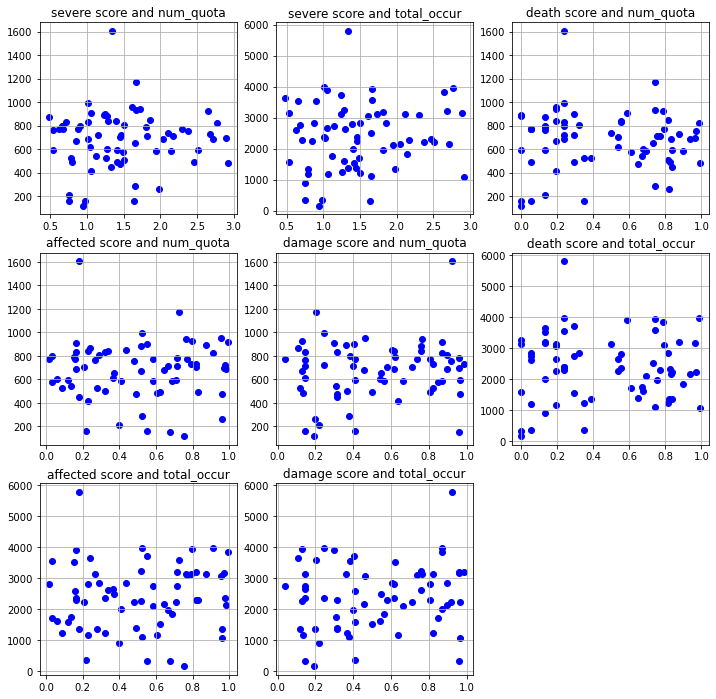

In [185]:
plt.figure(figsize = (12,12))
plt.subplot(3, 3, 1)
plt.scatter(dis_matchresult['severe score'], matchresult['num_quota'],color="blue")
plt.grid()  
plt.title('severe score and num_quota')
  

plt.subplot(3, 3, 2)
plt.scatter(dis_matchresult['severe score'], matchresult['total_occur'],color="blue")
plt.grid() 
plt.title('severe score and total_occur')



plt.subplot(3, 3, 3)
plt.scatter(dis_matchresult['death score'], matchresult['num_quota'],color="blue")
plt.grid()  
plt.title('death score and num_quota')


plt.subplot(3, 3, 4)
plt.scatter(dis_matchresult['affected score'], matchresult['num_quota'],color="blue")
plt.grid()  
plt.title('affected score and num_quota')


plt.subplot(3, 3, 5)
plt.scatter(dis_matchresult['damage score'], matchresult['num_quota'],color="blue")
plt.grid()  
plt.title('damage score and num_quota')


plt.subplot(3, 3, 6)
plt.scatter(dis_matchresult['death score'], matchresult['total_occur'],color="blue")
plt.grid()  
plt.title('death score and total_occur')
  

plt.subplot(3, 3, 7)
plt.scatter(dis_matchresult['affected score'], matchresult['total_occur'],color="blue")
plt.grid() 
plt.title('affected score and total_occur')


plt.subplot(3, 3, 8)
plt.scatter(dis_matchresult['damage score'], matchresult['total_occur'],color="blue")
plt.grid()  
plt.title('damage score and total_occur')
plt.show()



In [186]:
#calculate correlation value
import scipy.stats as stats

r1,p1 = stats.pearsonr(dis_matchresult['severe score'],matchresult['num_quota'])
print('Correlation coefficient between severe score and num_quota  r is = %6.3f，p value is = %6.3f'%(r1,p1))

r2,p2 = stats.pearsonr(dis_matchresult['severe score'],matchresult['total_occur'])
print('Correlation coefficient between severe score and total_occur  r is = %6.3f，p value is = %6.3f'%(r2,p2))

r3,p3 = stats.pearsonr(dis_matchresult['death score'],matchresult['num_quota'])
print('Correlation coefficient between death score and num_quota  r is = %6.3f，p value is = %6.3f'%(r3,p3))

r4,p4 = stats.pearsonr(dis_matchresult['affected score'],matchresult['num_quota'])
print('Correlation coefficient between affected score and num_quota  r is = %6.3f，p value is = %6.3f'%(r,p))

r5,p5 = stats.pearsonr(dis_matchresult['damage score'],matchresult['num_quota'])
print('Correlation coefficient between damage score and num_quota  r is = %6.3f，p value is = %6.3f'%(r5,p5))

r6,p6 = stats.pearsonr(dis_matchresult['death score'],matchresult['total_occur'])
print('Correlation coefficient between death score and total_occur  r is = %6.3f，p value is = %6.3f'%(r6,p6))

r7,p7 = stats.pearsonr(dis_matchresult['affected score'],matchresult['total_occur'])
print('Correlation coefficient between affected score and total_occur  r is = %6.3f，p value is = %6.3f'%(r7,p7))

r8,p8 = stats.pearsonr(dis_matchresult['damage score'],matchresult['total_occur'])
print('Correlation coefficient between damage score and total_occur  r is = %6.3f，p value is = %6.3f'%(r8,p8))








Correlation coefficient between severe score and num_quota  r is =  0.054，p value is =  0.665
Correlation coefficient between severe score and total_occur  r is =  0.113，p value is =  0.362
Correlation coefficient between death score and num_quota  r is = -0.009，p value is =  0.945
Correlation coefficient between affected score and num_quota  r is =  0.054，p value is =  0.665
Correlation coefficient between damage score and num_quota  r is =  0.140，p value is =  0.258
Correlation coefficient between death score and total_occur  r is =  0.021，p value is =  0.868
Correlation coefficient between affected score and total_occur  r is =  0.070，p value is =  0.574
Correlation coefficient between damage score and total_occur  r is =  0.155，p value is =  0.210


By looking at the graphs and calculating the correlation coefficients, we find that there is no correlation between the severity of disasters and the intensity of climate change reporting

In [187]:
ind_1 = matchresult["num_quota"].idxmax()
print(ind_1)
ind_2 = matchresult["total_occur"].idxmax()
print(ind_2)
print(type(ind_1))
dis_matchresult[dis_matchresult['StartDate'].isin([ind_1])]



2019-09-17 00:00:00
2019-09-17 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,Year,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,ISO,Region,...,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),StartDate,EndDate,death score,affected score,damage score,severe score,match
Dis No,,,,,,,,,,,,,,,,,,,,,
2019-0417-USA,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm ' Imelda',United States of America (the),USA,Northern America,...,NaN,1200000.0,3500000.0,2019-09-17,2019-09-21,0.238004,0.180422,0.923225,1.341651,True


In [188]:
#region analysis
matchresult_sort = matchresult.copy()
matchresult_sort = matchresult_sort.sort_values(by = "total_occur",ascending=False)
matchresult_sort_2 = matchresult_sort.iloc[:10]
matchresult_sort_2

,num_quota,total_occur,time,match
2019-09-17,1604,5792.0,2019-09-17,True
2019-12-09,992,3978.0,2019-12-09,True
2019-03-14,821,3964.0,2019-03-14,True
2019-11-09,930,3935.0,2019-11-09,True
2019-11-10,911,3897.0,2019-11-10,True
2019-05-03,922,3829.0,2019-05-03,True
2019-11-08,902,3720.0,2019-11-08,True
2019-11-12,870,3645.0,2019-11-12,True
2019-09-24,1170,3570.0,2019-09-24,True
2019-03-09,796,3549.0,2019-03-09,True


In [189]:
"""print(type(matchresult_sort_2.index))
temp_list5 = matchresult_sort_2.index
dis_matchresult[dis_matchresult['StartDate'].isin([matchresult_sort_2[temp_list5]])]"""
temp_list5 = matchresult_sort_2["time"].tolist()
print(type(temp_list5))
dis_matchresult[dis_matchresult['StartDate'].isin(temp_list5)]


<class 'list'>


,Year,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,ISO,Region,...,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),StartDate,EndDate,death score,affected score,damage score,severe score,match
Dis No,,,,,,,,,,,,,,,,,,,,,
2019-0082-IRN,2019,Natural,Hydrological,Flood,NaN,NaN,NaN,Iran (Islamic Republic of),IRN,Southern Asia,...,NaN,NaN,80000.0,2019-03-09,2019-03-10,0.238004,0.030710,0.383877,0.652591,True
2019-0110-MOZ,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Cyclone 'Idai',Mozambique,MOZ,Eastern Africa,...,NaN,150000.0,2000000.0,2019-03-14,2019-03-15,0.988484,0.913628,0.871401,2.773512,True
2019-0164-IND,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Cyclone 'Fani',India,IND,Southern Asia,...,NaN,NaN,1810000.0,2019-05-03,2019-05-03,0.786948,0.992322,0.867562,2.646833,True
2019-0417-USA,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm ' Imelda',United States of America (the),USA,Northern America,...,NaN,1200000.0,3500000.0,2019-09-17,2019-09-21,0.238004,0.180422,0.923225,1.341651,True
2019-0460-PAK,2019,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Pakistan,PAK,Southern Asia,...,NaN,NaN,17000.0,2019-09-24,2019-09-24,0.740883,0.725528,0.201536,1.667946,True
2019-0553-IRN,2019,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Iran (Islamic Republic of),IRN,Southern Asia,...,NaN,NaN,90000.0,2019-11-08,2019-11-08,0.291747,0.548944,0.404990,1.245681,True
2019-0550-BGD,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical cyclone 'Bulbul',Bangladesh,BGD,Southern Asia,...,NaN,NaN,5785.0,2019-11-09,2019-11-10,0.744722,0.796545,0.128599,1.669866,True
2019-0549-PHL,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical cyclone 'Nakri',Philippines (the),PHL,South-Eastern Asia,...,NaN,NaN,36000.0,2019-11-10,2019-11-10,0.587332,0.165067,0.295585,1.047985,True
2019-0549-VNM,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical cyclone 'Nakri',Viet Nam,VNM,South-Eastern Asia,...,NaN,NaN,4000.0,2019-11-12,2019-11-13,0.130518,0.239923,0.105566,0.476008,True


In [190]:
matchresult_sort_bynumquota = matchresult.copy()
matchresult_sort_bynumquota = matchresult_sort_bynumquota.sort_values(by = "num_quota",ascending=False)
matchresult_sort_bynumquota_2 = matchresult_sort_bynumquota.iloc[:10]
matchresult_sort_bynumquota_2

,num_quota,total_occur,time,match
2019-09-17,1604,5792.0,2019-09-17,True
2019-09-24,1170,3570.0,2019-09-24,True
2019-12-09,992,3978.0,2019-12-09,True
2019-12-02,956,3057.0,2019-12-02,True
2020-01-09,943,3125.0,2020-01-09,True
2019-11-09,930,3935.0,2019-11-09,True
2019-05-03,922,3829.0,2019-05-03,True
2019-11-10,911,3897.0,2019-11-10,True
2019-11-08,902,3720.0,2019-11-08,True
2020-01-12,893,3120.0,2020-01-12,True


In [191]:
temp_list6 = matchresult_sort_bynumquota_2["time"].tolist()
dis_matchresult[dis_matchresult['StartDate'].isin(temp_list6)]

,Year,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,ISO,Region,...,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),StartDate,EndDate,death score,affected score,damage score,severe score,match
Dis No,,,,,,,,,,,,,,,,,,,,,
2019-0164-IND,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Cyclone 'Fani',India,IND,Southern Asia,...,NaN,NaN,1810000.0,2019-05-03,2019-05-03,0.786948,0.992322,0.867562,2.646833,True
2019-0417-USA,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm ' Imelda',United States of America (the),USA,Northern America,...,NaN,1200000.0,3500000.0,2019-09-17,2019-09-21,0.238004,0.180422,0.923225,1.341651,True
2019-0460-PAK,2019,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Pakistan,PAK,Southern Asia,...,NaN,NaN,17000.0,2019-09-24,2019-09-24,0.740883,0.725528,0.201536,1.667946,True
2019-0553-IRN,2019,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Iran (Islamic Republic of),IRN,Southern Asia,...,NaN,NaN,90000.0,2019-11-08,2019-11-08,0.291747,0.548944,0.404990,1.245681,True
2019-0550-BGD,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical cyclone 'Bulbul',Bangladesh,BGD,Southern Asia,...,NaN,NaN,5785.0,2019-11-09,2019-11-10,0.744722,0.796545,0.128599,1.669866,True
2019-0549-PHL,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical cyclone 'Nakri',Philippines (the),PHL,South-Eastern Asia,...,NaN,NaN,36000.0,2019-11-10,2019-11-10,0.587332,0.165067,0.295585,1.047985,True
2019-0573-PHL,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical cyclone 'Kammuri' (Tisoy),Philippines (the),PHL,South-Eastern Asia,...,NaN,NaN,109151.0,2019-12-02,2019-12-03,0.193858,0.955854,0.464491,1.614203,True
2019-0601-MDG,2019,Natural,Meteorological,Storm,Tropical cyclone,NaN,Cyclone 'Belna',Madagascar,MDG,Eastern Africa,...,NaN,NaN,25000.0,2019-12-09,2019-12-10,0.238004,0.523992,0.247601,1.009597,True
2020-0017-IRN,2020,Natural,Hydrological,Flood,NaN,NaN,NaN,Iran (Islamic Republic of),IRN,Southern Asia,...,NaN,NaN,808000.0,2020-01-09,2020-01-22,0.193858,0.765835,0.765835,1.725528,True


By analyzing the countries where the disasters occurred in the above two tables, we found that more than half of them are in countries where English is the official language or unofficially the primary language spoken.  For example, historically, India, Pakistan and Bangladesh were all part of British India, and the Philippines was part of the U.S. colonies for a long time before independence. And among the natural disasters that caused the greatest climate change discussing is Tropical Storm Imelda happened in U.S.. Therefore, we can conclude that only a natural disaster in or around a country can trigger strong reports and discussions about climate change in that country, while if the natural disaster occurs in a distant place, people will not be concerned about climate change because of this natural disaster.For example, only tropical storms that occur within the United States generate strong discussions about climate change in the U.S. media.